## Practical T-tests in Large Online Experiments

**The 2-sample t-test tests for a significant difference of a variable between 2 groups.**

Suppose we are testing whether a new website design for our company to see if it loads signficantly faster for users when the website is used in production. Based on our setup, we would have 2 groups:

1. Treatment Group: the new version of the website
2. Control Group: the old version of the website

Since we are comparing the difference in load times between the two groups, this is a good setup for the 2-sample t-test! Let's do one from scratch, and I'll show the practical way to do this test afterwards.

To run this experiment, we would:
1. Set our hypotheses 
2. Randomly assign a user to the new or old version of the website
3. Record the website load time for each user in seconds
4. Calculate a t-statistic
5. Calculate p-values and confidence intervals and interpret them to make a conclusion


### Step 1: Set our hypotheses

Before we run our experiment, we need to have some hypotheses first to make conclusions about which website design is faster. We define our null and alternative hypotheses as follows:

Null: $\mu_{T} = \mu_{C}$. There is no significant difference in the average load time between the new and old websites.  
Alternative: $\mu_{T} \neq \mu_{C}$. The average load time for the new website is significantly different than the old website. 

### Step 2+3: Collecting the Data

This data is simulated, but let's assume the new design loads 50ms faster on average. While we are experimenting, we don't know this true value

In [26]:
# Simulation of our data
np.random.seed(67)
shape, scale = 1, 500
N = 10000

load_time = np.random.gamma(shape, scale, N) 
treated = np.random.choice([0,1], size = N, replace = True) # 1 if new website 0 if old
user_id = np.arange(N)

d = {
    'user_id' : user_id,
    'treated' : treated,
    'load_time' : load_time
}

data = pd.DataFrame(data = d)

n_treated = (data['treated'] == 1).sum()
data.loc[data['treated'] == 1, 'load_time'] = np.maximum(data.loc[data['treated'] == 1, 'load_time'] - 50 + np.random.normal(0, 100, size=n_treated), 0) # add effect of new website

data.head()


,user_id,treated,load_time
0,0,0,394.665444
1,1,0,978.989480
2,2,1,675.398536
3,3,1,254.174357
4,4,1,0.000000


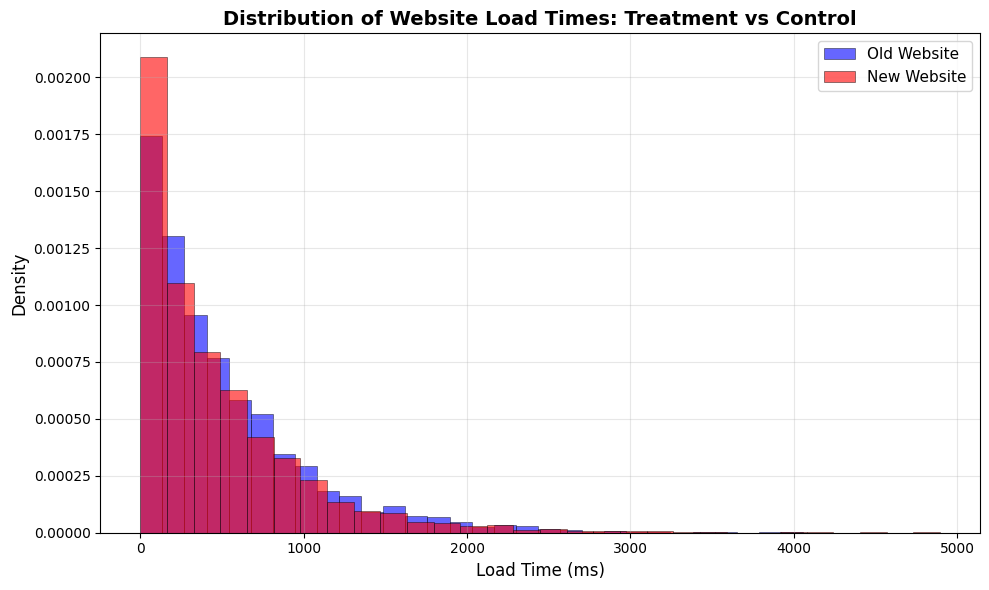

In [27]:
# Plot overlapping histograms for treated and control groups
fig, ax = plt.subplots(figsize=(10, 6))

# Separate data into treated and control groups
treated_data = data[data['treated'] == 1]['load_time']
control_data = data[data['treated'] == 0]['load_time']

# Plot both histograms on the same axes
# Use density=True so both are on the same scale
ax.hist(control_data, bins=30, alpha=0.6, color='blue', 
        edgecolor='black', linewidth=0.5, density=True, label='Old Website')
ax.hist(treated_data, bins=30, alpha=0.6, color='red', 
        edgecolor='black', linewidth=0.5, density=True, label='New Website')

# Add labels and title
ax.set_xlabel('Load Time (ms)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution of Website Load Times: Treatment vs Control', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Visually, it looks like the new website had faster load times compared to the old one. But to make sure it wasn't just by chance, we run a 2 sample t-test.

### Step 3: Calculate the t-statistic

To translate the problem into math, we define the following terms: 
- $Y_T$: the load time for a user that was shown the new design (treated)
- $Y_C$: the load time for a user that was shown the old design (control)  
- $\Delta$: $Y_T-Y_C$. The sample difference in the load time between the treated and control group
- $S^2_T$ : the sample variance of load times for the treated group
- $S^2_C$ : the sample variance of load times for the control group

The t-statistic is calculated by doing:

$$
\begin{aligned}
T &= \frac{\Delta - 0}{\sqrt{Var(\Delta)}}
\end{aligned}
$$

It looks complicated, but we are just standardizing $\Delta$ by subtracting the mean difference in load times (under the null hypothesis) and dividing by the standard deviation of $\Delta$.

To calculate the standard deviation, $Var(\Delta) = \frac{S_T^2}{n_T} + \frac{S_C^2}{n_C}$

In [28]:
# Calculate t-statistic
treated_data = data[data['treated'] == 1]['load_time']
control_data = data[data['treated'] == 0]['load_time']
n_t = treated_data.shape[0]
n_c = control_data.shape[0]

delta =  treated_data.mean() - control_data.mean()

variance_delta = (treated_data.var() / n_t) + (control_data.var() / n_c)

T = delta / np.sqrt(variance_delta)
print(f"T statistic: {T:.2f}")

T statistic: -5.42


### Step 4: Calculate the p-value and confidence intervals and interpret them

Based on our alternative hypothesis ($\mu_T < \mu_C$), we are only interested in the chances we received the observed difference in load times or something more extreme in the negative direction.


Since we are working with large datasets, **the t-statistic T is normally distributed**. The large number of samples lets us make this huge simplification. This lets us calculate the p-value by finding the area under the standard normal curve.

In [29]:
# Calculate p-value
p_value = 2 * norm.cdf(T)
print(f"P-value: {p_value}")

P-value: 6.028516132999586e-08


This p-value is practically 0, meaning that the probability that we observed the difference in load times or something more extreme in the negative direction, assumming the null hypothesis is true is 0.

Therefore, we can conclude that the new website design is loads significantly faster than the old one.

We can also do this by computing confidence intervals.

In [30]:
# Calculate confidence intervals
lower_bound = delta - (1.96 * np.sqrt(variance_delta))
upper_bound = delta + (1.96 * np.sqrt(variance_delta))
print(f"95% Confidence Interval: [{lower_bound:.2f}, {upper_bound:.2f}]")

95% Confidence Interval: [-75.54, -35.40]


This interval means that we are 95% confident that the true average difference in load times in this interval. Since it does not contain 0, we have the same conclusion that we got from calculating the p-value.

### Practical Implementation

We just did the manual calculations to show how the 2 sample t-test works under the hood, but that is tedious! Here is the practical implementation using statsmodels:

In [32]:
# Perform Welch's t-test (unequal variances)
test_result = stats.ttest_ind(
    treated_data,
    control_data,
    equal_var=False,        # Variances are not equal
)

# Get the 95% confidence interval for the difference in means
ci = test_result.confidence_interval(confidence_level=0.95)

# Print the bare-bones output
print(f"P-value: {test_result.pvalue}")
print(f"95% Confidence Interval:: [{ci.low:.2f}, {ci.high:.2f}]")

P-value: 6.168911847774043e-08
95% Confidence Interval:: [-75.54, -35.40]


As you can see, the results we get from doing a proper t-test matches what we did from scratch with simplifications! This is all because we had a large dataset of 10K users.